In [64]:
from relapse_prediction import constants

from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from multiprocessing import Pool
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle


In [65]:
def get_list_thresholds(imaging, label, feature):

    list_thresholds = set()

    for patient in constants.list_patients:

        with open(constants.dir_thresholds / label / imaging / f"{imaging}_{feature}" / f"{patient}.pickle", "rb") as f:
            dict_thresholds = pickle.load(f)

        list_thresholds = list_thresholds.union(set(dict_thresholds["thresholds"]))

    return sorted(list(list_thresholds))
    

In [66]:
imaging = "T1"
label = "L3R"
feature = "mean_5x5x5"

In [67]:
list_thresholds = get_list_thresholds(imaging, label, feature)

FileNotFoundError: [Errno 2] No such file or directory: 'E:Relapse prediction\\results\\thresholds per patient\\L3R\\T1\\T1_mean_5x5x5\\AIDREAM_1.pickle'

In [68]:
def load_threshold_dataframe(patient, imaging, label, feature):

    with open(constants.dir_thresholds / label / imaging / f"{imaging}_{feature}" / f"{patient}.pickle", "rb") as f:
        dict_thresholds = pickle.load(f)

    df_labels = pd.read_parquet(constants.dir_labels / f"{patient}_labels.parquet", engine="pyarrow")
    total_positives = len(df_labels[df_labels[label] == 1])
    total_negatives = len(df_labels[df_labels[label] == 0])

    df_thresholds = pd.DataFrame(columns=["thresholds", "TP", "FP"])

    df_thresholds["thresholds"] = dict_thresholds["thresholds"]

    df_thresholds["TP"] = dict_thresholds["tpr"] * total_positives
    df_thresholds["FP"] = dict_thresholds["fpr"] * total_negatives

    return df_thresholds, total_positives, total_negatives
    

In [60]:
def get_all_fpr_tpr(imaging, label, feature, list_thresholds):

    df_total = pd.DataFrame(columns=["thresholds", "TP", "FP"])
    df_total["thresholds"] = list(list_thresholds)
    df_total["TP"] = 0
    df_total["FP"] = 0
    total_positives = 0
    top_negatives = 0

    for patient in tqdm(constants.list_patients):

        df_thresholds = pd.DataFrame(list(list_thresholds), columns=["thresholds"])
        _df_thresholds, t_p, t_n = load_threshold_dataframe(patient, imaging, label, feature)

        if t_p > 0 and t_n > 0:
        
            df_thresholds = df_thresholds.merge(_df_thresholds, on="thresholds", how="left")
    
            df_thresholds = df_thresholds.sort_values(by="thresholds", ascending=True).reset_index(drop=True)
    
            df_thresholds["TP"] = df_thresholds["TP"].bfill()
            df_thresholds["FP"] = df_thresholds["FP"].bfill()
    
            idx = (df_thresholds["TP"].isna()) & (df_thresholds["FP"].isna())
            df_thresholds.loc[idx, "TP"] = 0
            df_thresholds.loc[idx, "FP"] = 0
    
            df_total["TP"] = df_total["TP"] + df_thresholds["TP"]
            df_total["FP"] = df_total["FP"] + df_thresholds["FP"]
            total_positives += t_p
            top_negatives += t_n

    df_total["tpr"] = df_total["TP"] / total_positives
    df_total["fpr"] = df_total["FP"] / top_negatives

    dict_fpr_tpr = {
        "fpr": list(df_total["fpr"]),
        "tpr": list(df_total["tpr"]),
        "thresholds": list(df_total["thresholds"])
    }

    # dir_save = constants.dir_results / "total_ROC"
    # dir_save.mkdir(parents=True, exist_ok=True)

    # with open(dir_save / f"{label}_{imaging}_{feature}_total_tpr_fpr.pickle", "wb") as f:
    #     pickle.dump(dict_fpr_tpr, f)

    return dict_fpr_tpr

In [61]:
dict_fpr_tpr = get_all_fpr_tpr(imaging, label, feature, list_thresholds)

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:20<00:00,  4.98it/s]


In [62]:
fpr = dict_fpr_tpr["fpr"]
tpr = dict_fpr_tpr["tpr"]

roc_auc = auc(fpr, tpr)


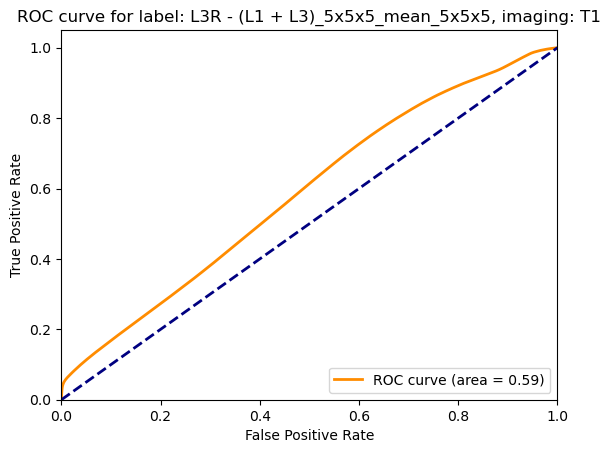

In [63]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve for label: {f"{label}_{feature}"}, imaging: {imaging}')
plt.legend(loc="lower right")

In [2]:



def plot_total_roc(imaging, label, feature, dict_fpr_tpr):

    fpr = dict_fpr_tpr["fpr"]
    tpr = dict_fpr_tpr["tpr"]

    roc_auc = auc(fpr, tpr)

    print(f"ROC AUC: {roc_auc}")

    dir_save = constants.dir_results / "total_ROC"
    dir_save.mkdir(parents=True, exist_ok=True)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for label: {f"{label}_{feature}"}, imaging: {imaging}')
    plt.legend(loc="lower right")

    # plt.savefig(str(dir_save / f"{label}_{imaging}_{feature}.png"), dpi=300)
    # plt.clf()


def compute_cutoff_youden(fpr, tpr, thresholds, inverted=False):
    """
    Compute the cutoff value for the ROC curve.
    :param fpr: False Positive Rate
    :param tpr: True Positive Rate
    :param thresholds: Thresholds
    :return: Cutoff value
    """
    # Compute the Youden index for each point of the ROC curve :
    if inverted:
        youden = fpr + (1 - tpr) - 1
    else:
        youden = tpr + (1 - fpr) - 1
    # Find the index of the point that maximizes the Youden index :
    idx_max = np.argmax(youden)
    # Return the corresponding threshold :
    return thresholds[idx_max]


def print_cutoff(label, imaging, feature, dict_fpr_tpr):

    tpr = np.array(dict_fpr_tpr["tpr"])
    fpr = np.array(dict_fpr_tpr["fpr"])
    thresholds = dict_fpr_tpr["thresholds"]

    cutoff = compute_cutoff_youden(fpr, tpr, thresholds, inverted=False)

    txt = f"Cutoff value for label={label}, imaging={imaging}, feature={feature}: {cutoff}"

    with open(constants.dir_results / "total_cuttofs.txt", "a+") as f:
        f.write(txt + "\n")

    print(f"Cutoff value for label={label}, imaging={imaging}, feature={feature}", cutoff)


def main():

    list_imaging = constants.L_IRM_MAPS + constants.L_CERCARE_MAPS
    list_labels = ["L3R_5x5x5", "L3R - (L1 + L3)_5x5x5"]
    list_features = ["mean_5x5x5"]

    for imaging in constants.L_IRM_MAPS:
        for label in list_labels:
            for feature in list_features:

                print("get list of thresholds ...")
                list_thresholds = get_list_thresholds(imaging, label, feature)
                print(f"aggregate tpr, fpr for {imaging}, {label}, {feature} ...")
                dict_fpr_tpr = get_all_fpr_tpr(imaging, label, feature, list_thresholds)
                print(f"plot total roc for {imaging}, {label}, {feature} ...")
                plot_total_roc(imaging, label, feature, dict_fpr_tpr)

                print_cutoff(label, imaging, feature, dict_fpr_tpr)


if __name__ == "__main__":
    main()


In [6]:
constants.L_CERCARE_MAPS

['COV', 'CTH', 'Delay', 'rCBV', 'rLeakage', 'OEF', 'rCMRO2']

In [7]:
constants.L_IRM_MAPS

['T1CE', 'T1', 'FLAIR']